In [2]:
import pandas as pd, re
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
import calendar
import matplotlib.dates as mdates
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error
import math
import holidays
from operator import itemgetter

In [3]:
df = pd.read_csv('demandForecastingData.csv', parse_dates=['Date'])

In [4]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Quarter', 'Hour', 'Minute', 'Day', 'Dayofweek', 'Dayofyear']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)
        

In [5]:
add_datepart(df, 'Date', drop=False)

In [7]:
#2018-07-01 00:00:00
#2013-01-01 00:00:00
end_date = datetime(2018, 7, 1)
start_date = datetime(2013, 1, 1)

start_date_displaced_day = start_date - timedelta(minutes=1440)
end_date_displaced_day = end_date - timedelta(minutes=1440)

start_date_displaced_week = start_date - timedelta(minutes=10080)
end_date_displaced_week = end_date - timedelta(minutes=10080)

start_date_displaced_year = start_date - timedelta(minutes=524160)
end_date_displaced_year = end_date - timedelta(minutes=524160)

ranged_df = df[(df.Date >= start_date) & (df.Date <= end_date)].reset_index(drop=True)

df_same_day_displaced  = df[(df.Date >= start_date_displaced_day) & (df.Date <= end_date_displaced_day)].reset_index(drop=True)
df_same_week_displaced  = df[(df.Date >= start_date_displaced_week) & (df.Date <= end_date_displaced_week)].reset_index(drop=True)
df_same_year_displaced  = df[(df.Date >= start_date_displaced_year) & (df.Date <= end_date_displaced_year)].reset_index(drop=True)

ranged_df['Load Last Day'] = df_same_day_displaced['Load']
ranged_df['Load Last Week'] = df_same_week_displaced['Load']
ranged_df['Load Last Year'] = df_same_year_displaced['Load']

ranged_df.head()

,Date,Load,Temperature,Temperature-6hrs,Temperature-12hrs,Temperature-18hrs,Temperature-24hrs,Temperature-36hrs,Temperature-48hrs,Temperature-72hrs,...,Week,Quarter,Hour,Minute,Day,Dayofweek,Dayofyear,Load Last Day,Load Last Week,Load Last Year
0,2013-01-01 00:00:00,840.57,2.7,4.4,6.8,9.9,9.8,8.2,4.7,2.4,...,1,1,0,0,1,1,1,784.39,868.02,865.41
1,2013-01-01 00:30:00,819.25,2.7,4.4,6.8,9.9,9.8,8.2,4.7,2.4,...,1,1,0,30,1,1,1,744.19,805.28,833.36
2,2013-01-01 01:00:00,818.26,2.7,4.0,6.8,10.0,10.1,9.3,5.0,2.4,...,1,1,1,0,1,1,1,743.33,789.54,823.01
3,2013-01-01 01:30:00,799.11,2.7,4.0,6.8,10.0,10.1,9.3,5.0,2.4,...,1,1,1,30,1,1,1,726.10,751.77,809.48
4,2013-01-01 02:00:00,764.40,3.1,3.3,7.2,10.0,10.2,9.6,5.7,2.8,...,1,1,2,0,1,1,1,704.08,709.98,797.16


In [8]:
ranged_df.corr()

,Load,Temperature,Temperature-6hrs,Temperature-12hrs,Temperature-18hrs,Temperature-24hrs,Temperature-36hrs,Temperature-48hrs,Temperature-72hrs,Temperature-96hrs,...,Week,Quarter,Hour,Minute,Day,Dayofweek,Dayofyear,Load Last Day,Load Last Week,Load Last Year
Load,1.000000,-0.120053,-0.286408,-0.498603,-0.268656,-0.114136,-0.285008,-0.499001,-0.267490,-0.112890,...,-4.372057e-02,-0.041883,5.642578e-01,-3.717372e-03,-0.031713,-0.120144,-4.540258e-02,0.928988,0.961703,0.959353
Temperature,-0.120053,1.000000,0.834767,0.698111,0.765774,0.852326,0.726343,0.619905,0.701756,0.800152,...,1.665411e-01,0.163934,1.509452e-01,2.163571e-05,0.053642,-0.003480,1.639012e-01,-0.108823,-0.102090,-0.071169
Temperature-6hrs,-0.286408,0.834767,1.000000,0.834636,0.697839,0.765568,0.852085,0.726111,0.619597,0.701754,...,1.719555e-01,0.168762,1.507895e-01,1.597256e-05,0.054246,-0.002028,1.680129e-01,-0.280799,-0.277298,-0.247344
Temperature-12hrs,-0.498603,0.698111,0.834636,1.000000,0.834475,0.697675,0.765161,0.851719,0.725783,0.619610,...,1.756899e-01,0.172458,-1.859859e-01,1.008965e-05,0.054741,-0.001474,1.710819e-01,-0.492194,-0.490318,-0.467101
Temperature-18hrs,-0.268656,0.765774,0.697839,0.834475,1.000000,0.834412,0.697474,0.764959,0.851546,0.725699,...,1.771958e-01,0.174136,-1.142071e-01,1.072202e-05,0.055090,-0.001516,1.718414e-01,-0.264041,-0.256094,-0.233967
Temperature-24hrs,-0.114136,0.852326,0.765568,0.697675,0.834412,1.000000,0.834445,0.697529,0.764827,0.851436,...,1.774189e-01,0.174556,1.509931e-01,1.177428e-05,0.054984,-0.000458,1.711914e-01,-0.119124,-0.101591,-0.070660
Temperature-36hrs,-0.285008,0.726343,0.852085,0.765161,0.697474,0.834445,1.000000,0.834288,0.697295,0.764893,...,1.785543e-01,0.176045,1.511381e-01,1.029995e-05,0.056312,0.002902,1.725463e-01,-0.286823,-0.276205,-0.245528
Temperature-48hrs,-0.499001,0.619905,0.726111,0.851719,0.764959,0.697529,0.834288,1.000000,0.834275,0.697688,...,1.816381e-01,0.178064,-1.855938e-01,1.093347e-05,0.057311,0.006186,1.752005e-01,-0.497265,-0.490842,-0.466159
Temperature-72hrs,-0.267490,0.701756,0.619597,0.725783,0.851546,0.764827,0.697295,0.834275,1.000000,0.834367,...,1.850124e-01,0.180125,-1.141935e-01,1.937773e-05,0.058053,0.006338,1.781394e-01,-0.265562,-0.257837,-0.233631
Temperature-96hrs,-0.112890,0.800152,0.701754,0.619610,0.725699,0.851436,0.764893,0.697688,0.834367,1.000000,...,1.880134e-01,0.181624,1.505571e-01,1.516165e-05,0.059219,0.006905,1.804232e-01,-0.113724,-0.103859,-0.070953


Text(0.5, 0, 'Predicted Load')

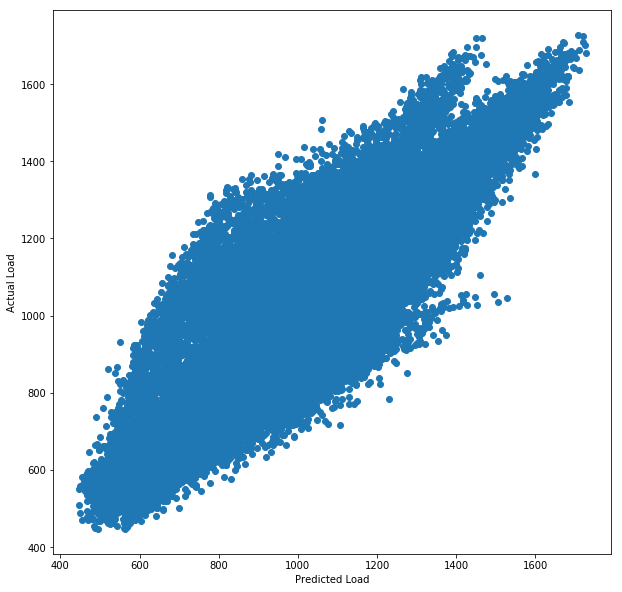

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(ranged_df['Load Last Day'], ranged_df['Load'])
plt.ylabel('Actual Load')
plt.xlabel('Predicted Load')

Text(0.5, 0, 'Predicted Load')

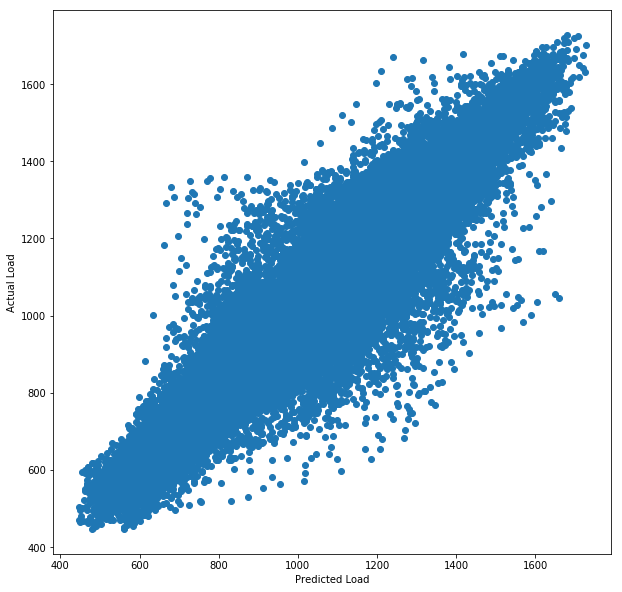

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(ranged_df['Load Last Week'], ranged_df['Load'])
plt.ylabel('Actual Load')
plt.xlabel('Predicted Load')

Text(0.5, 0, 'Predicted Load')

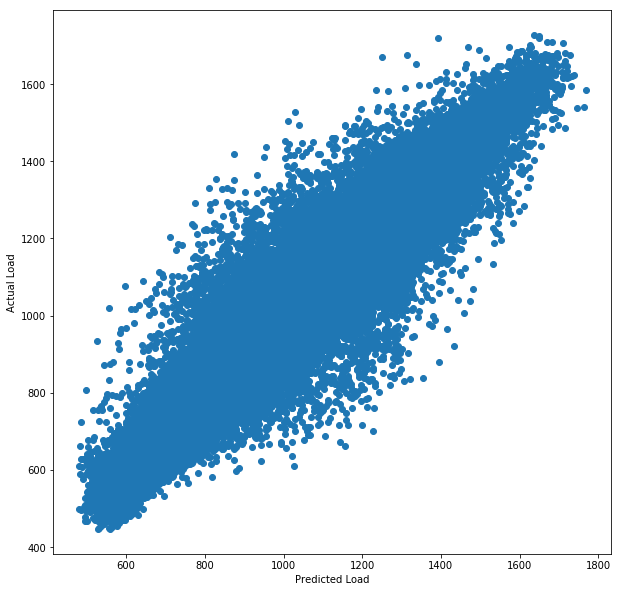

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(ranged_df['Load Last Year'], ranged_df['Load'])
plt.ylabel('Actual Load')
plt.xlabel('Predicted Load')

<b>
Over 2013-2018, in terms of correlation: SDLY > SDLW > SDLD. </b>

Monday 0.9514812023207587
Tuesday 0.9659114691000629
Wednesday 0.9693153596466941
Thursday 0.9645827642241387
Friday 0.9635995355485346
Saturday 0.9655674545671982
Sunday 0.9718893059493219


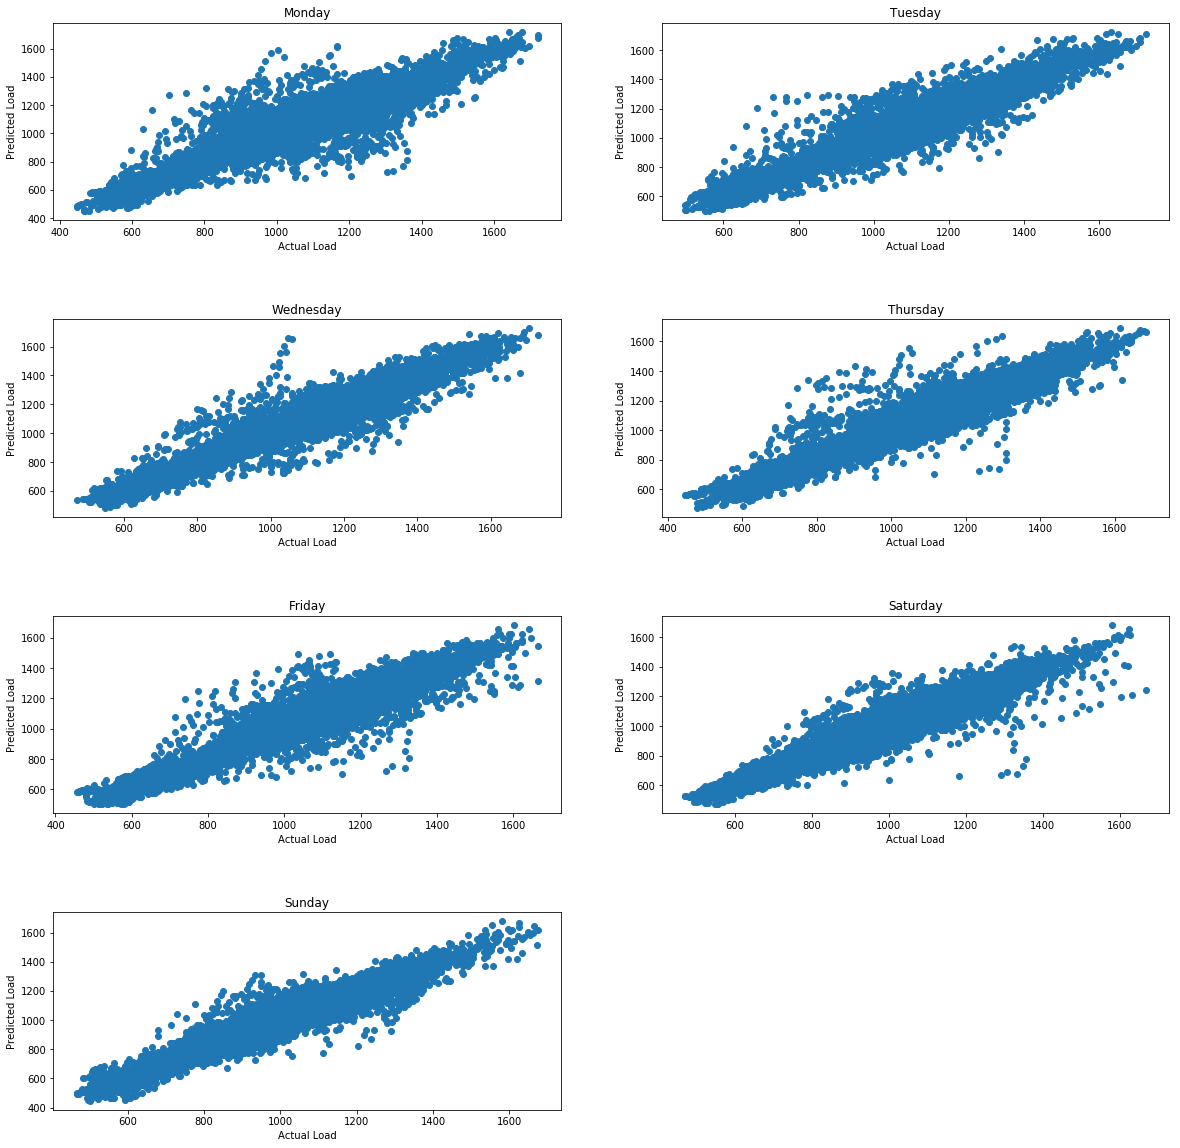

In [12]:
plt.figure(figsize=(20,20))

df_exclude_2018 = ranged_df[ranged_df.Year != 2018]
for i in range(0, 7):
    plt.subplot(4, 2, i+1)
    plt.title(i)
    specificday = df_exclude_2018[df_exclude_2018['Dayofweek'] == i]
    plt.scatter(specificday['Load'], specificday['Load Last Week'])
    plt.title(calendar.day_name[i])
    plt.ylabel('Predicted Load')
    plt.xlabel('Actual Load')
    correlation_specificday = specificday.corr()['Load']['Load Last Week']
    print(f'{calendar.day_name[i]} {correlation_specificday}')
    
plt.subplots_adjust(hspace = 0.5)

<b> Wednesday has the strongest correlation to load last year, Monday the weakest correlation. </b>